# Exchange Rate Prediction

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM, InputLayer
from keras.models import Sequential
from keras.callbacks import EarlyStopping

### Utility

In [32]:
def plot_series(series):    
    plt.figure(figsize=(12,6))
    plt.xlabel('Time')
    plt.ylabel('Exchange Rate')
    plt.grid(True)
    plt.plot(series)

### Download and preview data

In [33]:
end = datetime.now()
start = datetime(end.year-5,end.month,end.day)
currency = "CADCNY=X"
df = yf.download(currency, start,end)

[*********************100%%**********************]  1 of 1 completed


In [34]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-13,5.0724,5.1213,5.0720,5.0728,5.0728,0
2019-05-14,5.0953,5.1149,5.0911,5.0951,5.0951,0
2019-05-15,5.0572,5.1186,5.0572,5.1020,5.1020,0
2019-05-16,5.0683,5.1316,5.0679,5.1084,5.1084,0
2019-05-17,5.1062,5.1405,5.0814,5.1072,5.1072,0


In [35]:
df.drop('Volume', axis=1, inplace=True)

In [36]:
df.shape

(1305, 5)

In [37]:
df.describe()

,Open,High,Low,Close,Adj Close
count,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000
mean,5.181510,5.199678,5.154551,5.183136,5.183136
std,0.116163,0.115258,0.116564,0.115856,0.115856
min,4.860398,4.915445,4.801252,4.872813,4.872813
25%,5.088836,5.106270,5.061405,5.090204,5.090204
50%,5.188094,5.208979,5.159564,5.189989,5.189989
75%,5.264690,5.282016,5.239141,5.266287,5.266287
max,5.496837,5.500776,5.443882,5.496722,5.496722


In [38]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Exchange Rate')

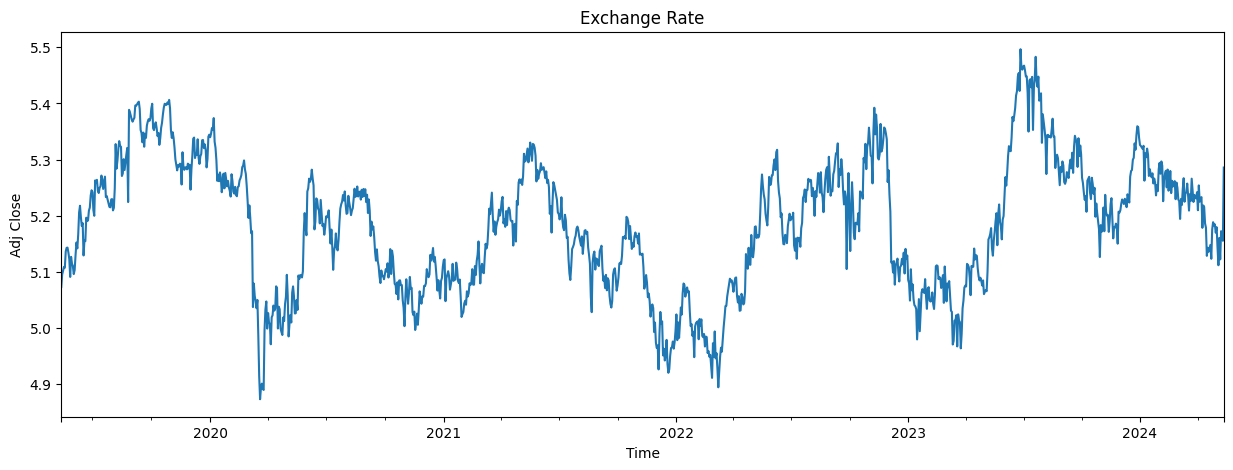

In [39]:
plt.figure(figsize = (15,5))
df['Adj Close'].plot()
plt.xlabel("Time")
plt.ylabel("Adj Close")
plt.title("Exchange Rate")

In [40]:
def plot_graph(figsize, values, column_name):
    plt.figure()
    values.plot(figsize = figsize)
    plt.xlabel("Time")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Exchange Rate")

In [41]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close'], dtype='object')

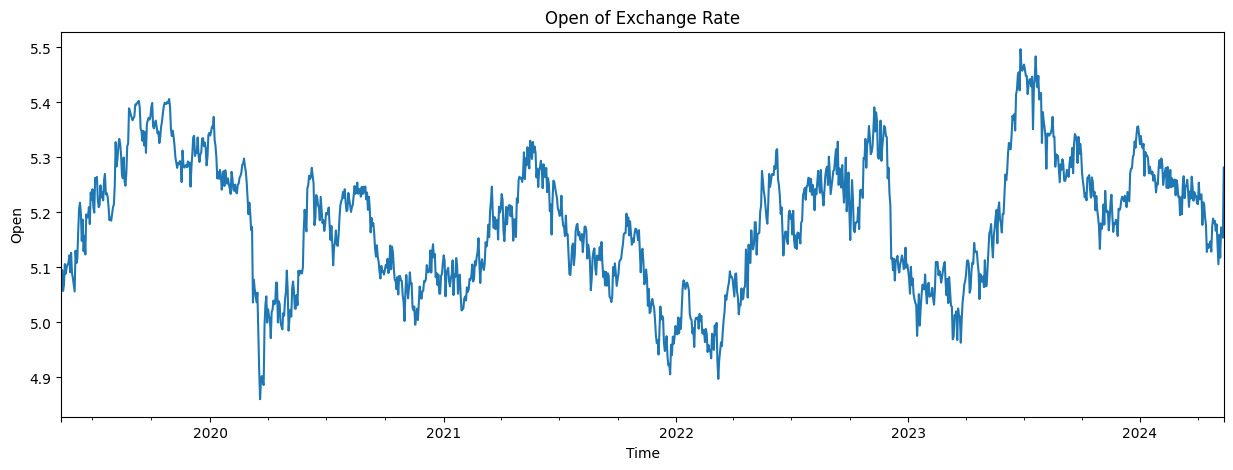

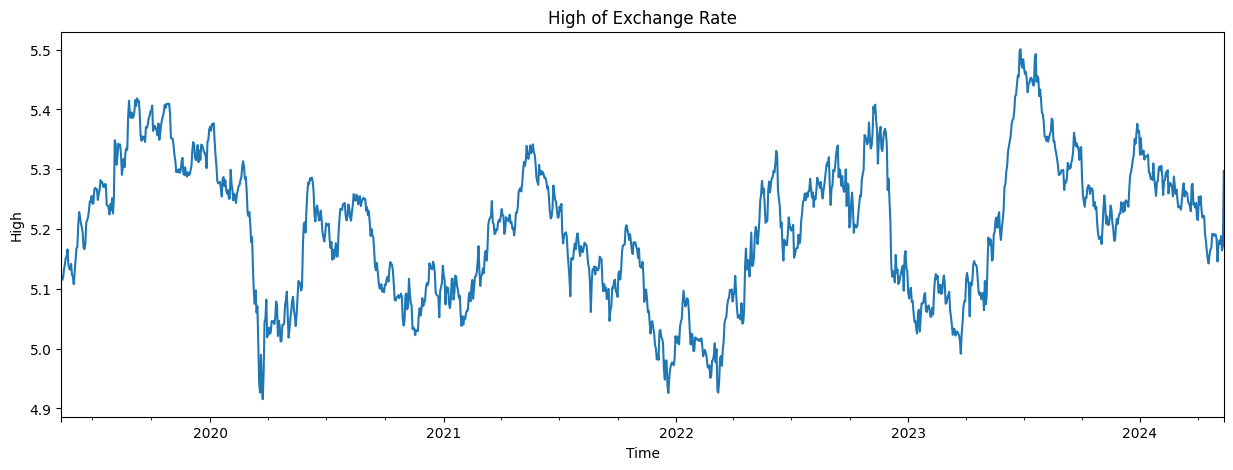

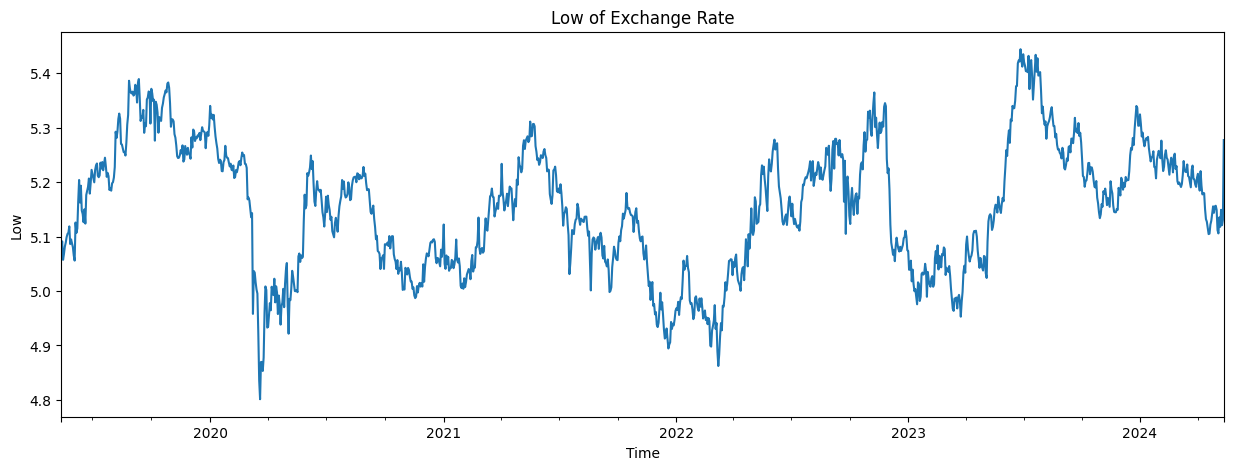

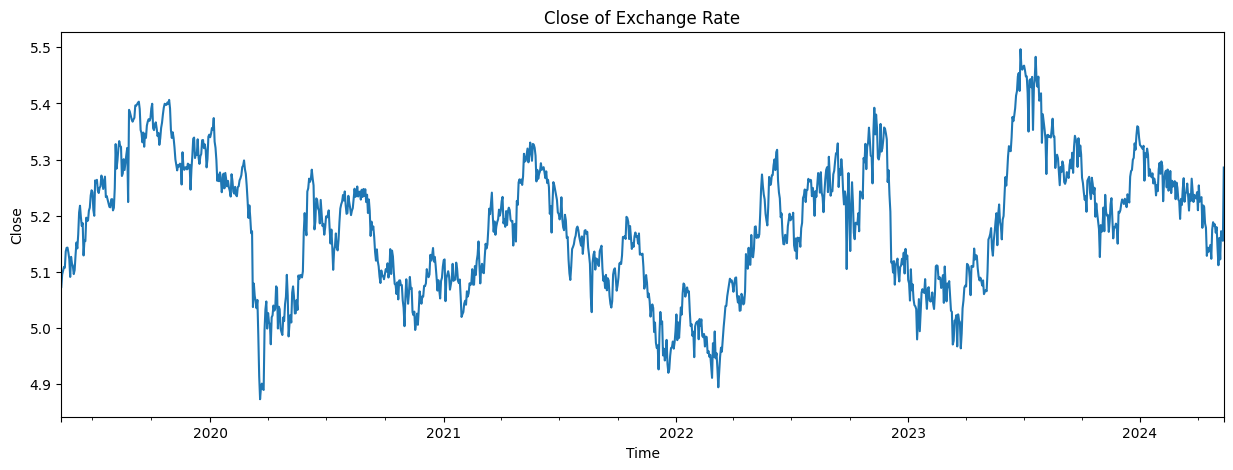

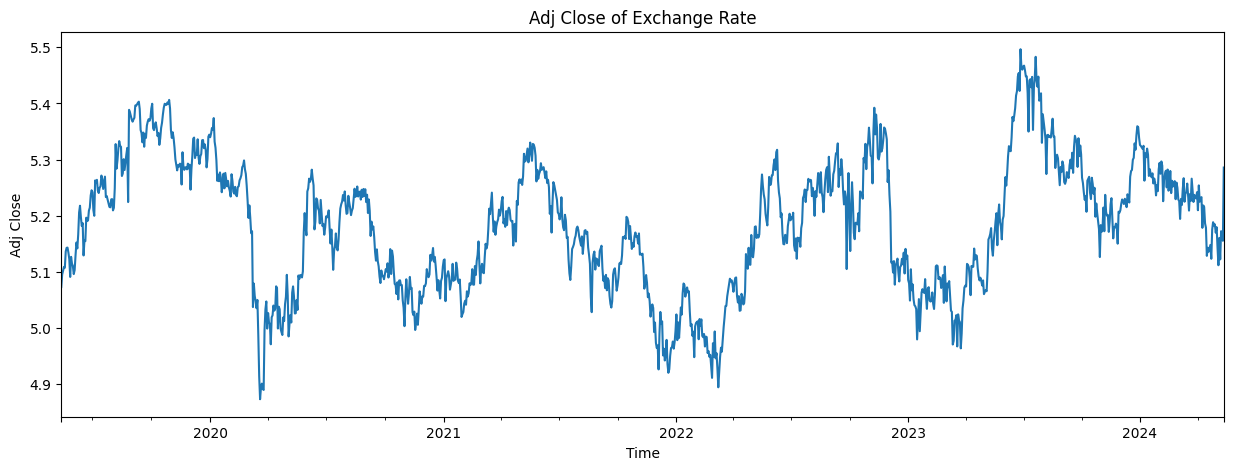

In [42]:
for column in df.columns:
    plot_graph((15,5),df[column], column)

<Figure size 640x480 with 0 Axes>

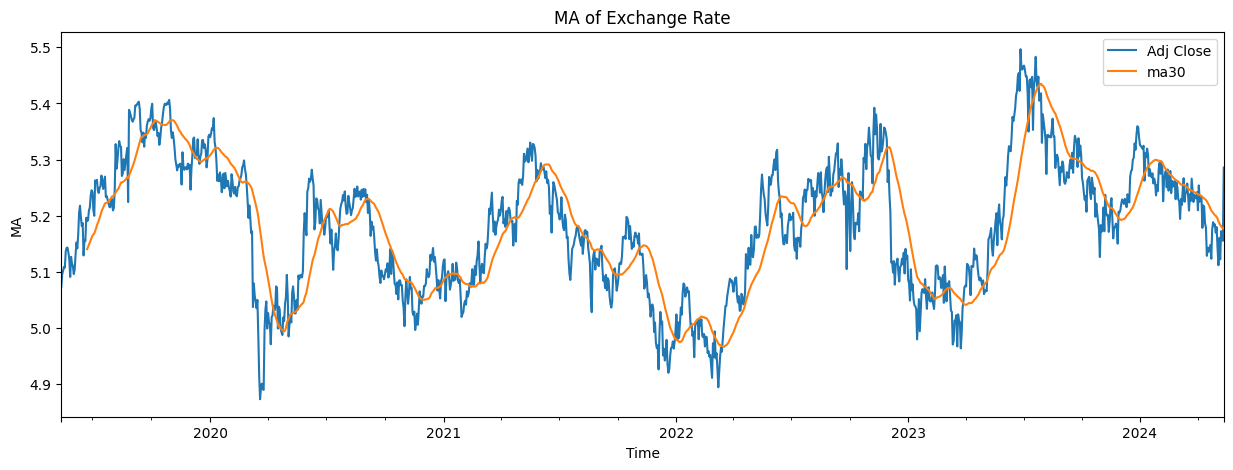

In [43]:
df['ma30']=df['Adj Close'].rolling(30).mean()
plot_graph((15,5), df[['Adj Close','ma30']], 'MA')

In [44]:
df['percentage_change_cp'] = df['Close'].pct_change()
df.head()

,Open,High,Low,Close,Adj Close,ma30,percentage_change_cp
Date,,,,,,,
2019-05-13,5.0724,5.1213,5.0720,5.0728,5.0728,NaN,NaN
2019-05-14,5.0953,5.1149,5.0911,5.0951,5.0951,NaN,0.004396
2019-05-15,5.0572,5.1186,5.0572,5.1020,5.1020,NaN,0.001354
2019-05-16,5.0683,5.1316,5.0679,5.1084,5.1084,NaN,0.001254
2019-05-17,5.1062,5.1405,5.0814,5.1072,5.1072,NaN,-0.000235


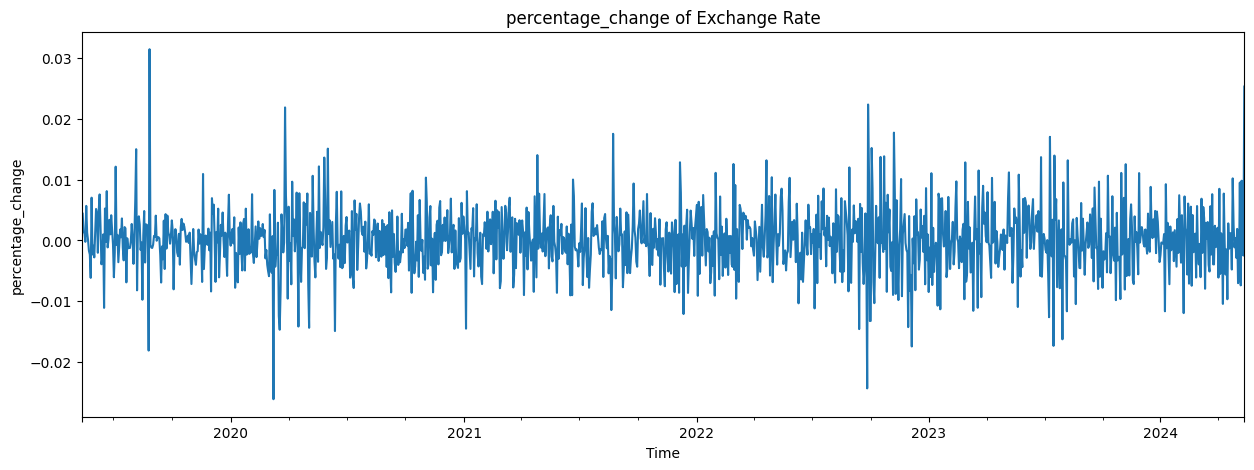

In [45]:
plot_graph((15,5), df['percentage_change_cp'], 'percentage_change')

In [46]:
Adj_close_price = df[['Adj Close']]

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Adj_close_price)
scaled_data

array([[0.32053863],
       [0.35628065],
       [0.36734045],
       ...,
       [0.47338417],
       [0.45271822],
       [0.66193428]])

In [48]:
max(Adj_close_price.values),min(Adj_close_price.values) 

(array([5.49672222]), array([4.87281322]))

In [49]:
len(scaled_data)

1305

In [50]:
x_data = []
y_data = []
period = 10
for i in range(period, len(scaled_data)):
    x_data.append(scaled_data[i - period: i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

In [51]:
x_data[0],y_data[0]

(array([[0.32053863],
        [0.35628065],
        [0.36734045],
        [0.37759777],
        [0.37567485],
        [0.42215568],
        [0.43257426],
        [0.43321472],
        [0.41911081],
        [0.40003684]]),
 array([0.34938843]))

In [52]:
int(len(x_data)*0.7)

906

In [53]:
splitting_len = int(len(x_data)*0.7)
x_train = x_data[:splitting_len]
y_train = y_data[:splitting_len]

x_test = x_data[splitting_len:]
y_test = y_data[splitting_len:]

In [54]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(906, 10, 1)
(906, 1)
(389, 10, 1)
(389, 1)


### Model

In [78]:
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1], 1)))

model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 64))

model.add(Dense(units = 64))
model.add(Dense(units = 32))
model.add(Dense(units = 10))
model.add(Dense(units = 1))


In [79]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 128)           66560     
                                                                 
 dropout_4 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_7 (LSTM)               (None, 10, 64)            49408     
                                                                 
 dropout_5 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 32)               

In [80]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [81]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=1, epochs = 50, callbacks=[early_stopping])

Epoch 1/50
906/906 [==============================] - 10s 7ms/step - loss: 0.0100
Epoch 2/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0061
Epoch 3/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0052
Epoch 4/50
906/906 [==============================] - 5s 6ms/step - loss: 0.0042
Epoch 5/50
906/906 [==============================] - 5s 6ms/step - loss: 0.0036
Epoch 6/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0039
Epoch 7/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0034
Epoch 8/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 9/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0034
Epoch 10/50
906/906 [==============================] - 5s 6ms/step - loss: 0.0032
Epoch 11/50
906/906 [==============================] - 6s 6ms/step - loss: 0.0031
Epoch 12/50
906/906 [==============================] - 5s 6ms/step - loss: 0.0032
Epoch 13/50
906/906 [===

### Prediction

In [82]:
predictions = model.predict(x_test)

13/13 [==============================] - 1s 5ms/step


In [83]:
inv_predictions = scaler.inverse_transform(predictions)
inv_predictions

array([[5.3612995],
       [5.3359118],
       [5.3262744],
       [5.3254333],
       [5.355771 ],
       [5.333254 ],
       [5.3383718],
       [5.341045 ],
       [5.354675 ],
       [5.355315 ],
       [5.354027 ],
       [5.3483844],
       [5.3058777],
       [5.3102446],
       [5.273179 ],
       [5.246087 ],
       [5.17378  ],
       [5.1543756],
       [5.1288815],
       [5.145442 ],
       [5.1127143],
       [5.141125 ],
       [5.142109 ],
       [5.149546 ],
       [5.129909 ],
       [5.113218 ],
       [5.133759 ],
       [5.1351633],
       [5.1475453],
       [5.1405573],
       [5.1590695],
       [5.1304426],
       [5.168406 ],
       [5.1518717],
       [5.156322 ],
       [5.1214027],
       [5.1094465],
       [5.08134  ],
       [5.132581 ],
       [5.1027904],
       [5.106871 ],
       [5.084033 ],
       [5.070591 ],
       [5.0662932],
       [5.0612626],
       [5.023018 ],
       [5.048002 ],
       [5.0753593],
       [5.039034 ],
       [5.0583625],


In [84]:
inv_y_test = scaler.inverse_transform(y_test)
inv_y_test

array([[5.30369377],
       [5.30013895],
       [5.30991697],
       [5.36354685],
       [5.31426907],
       [5.31990385],
       [5.33405876],
       [5.35717106],
       [5.35495186],
       [5.34660387],
       [5.33607578],
       [5.25991297],
       [5.28100395],
       [5.23704576],
       [5.20727301],
       [5.11635208],
       [5.11796379],
       [5.09871817],
       [5.1190238 ],
       [5.07705212],
       [5.11134291],
       [5.11647606],
       [5.12344599],
       [5.09880686],
       [5.08272982],
       [5.10857916],
       [5.1109972 ],
       [5.12307787],
       [5.1133852 ],
       [5.134058  ],
       [5.09696007],
       [5.14080477],
       [5.1239872 ],
       [5.12895918],
       [5.08537292],
       [5.07932711],
       [5.04864979],
       [5.10448694],
       [5.06699419],
       [5.07745504],
       [5.05111504],
       [5.04046202],
       [5.03850317],
       [5.03347588],
       [4.97939491],
       [5.01769209],
       [5.05128288],
       [4.993

In [85]:
rmse = np.sqrt(np.mean( (inv_predictions - inv_y_test)**2))

In [86]:
rmse

0.03642054695324834

In [87]:
ploting_data = pd.DataFrame(
 {
  'original_test_data': inv_y_test.reshape(-1),
    'predictions': inv_predictions.reshape(-1)
 } ,
    index = df.index[splitting_len+period:]
)
ploting_data.head()

,original_test_data,predictions
Date,,
2022-11-15,5.303694,5.361300
2022-11-16,5.300139,5.335912
2022-11-17,5.309917,5.326274
2022-11-18,5.363547,5.325433
2022-11-21,5.314269,5.355771


<Figure size 640x480 with 0 Axes>

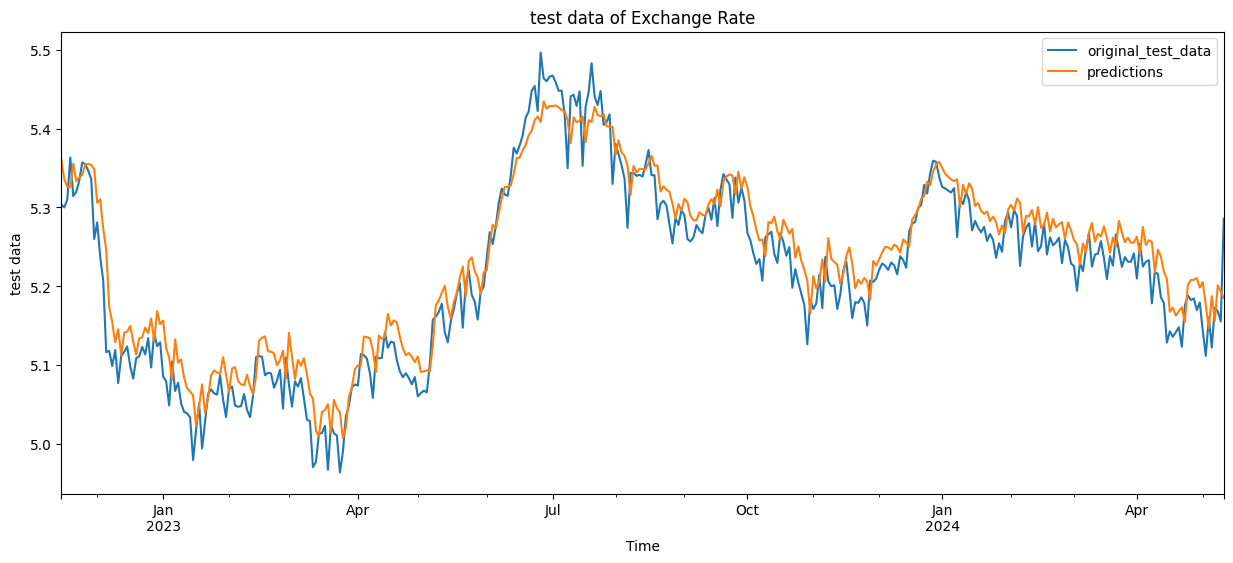

In [88]:
plot_graph((15,6), ploting_data, 'test data')

<Figure size 640x480 with 0 Axes>

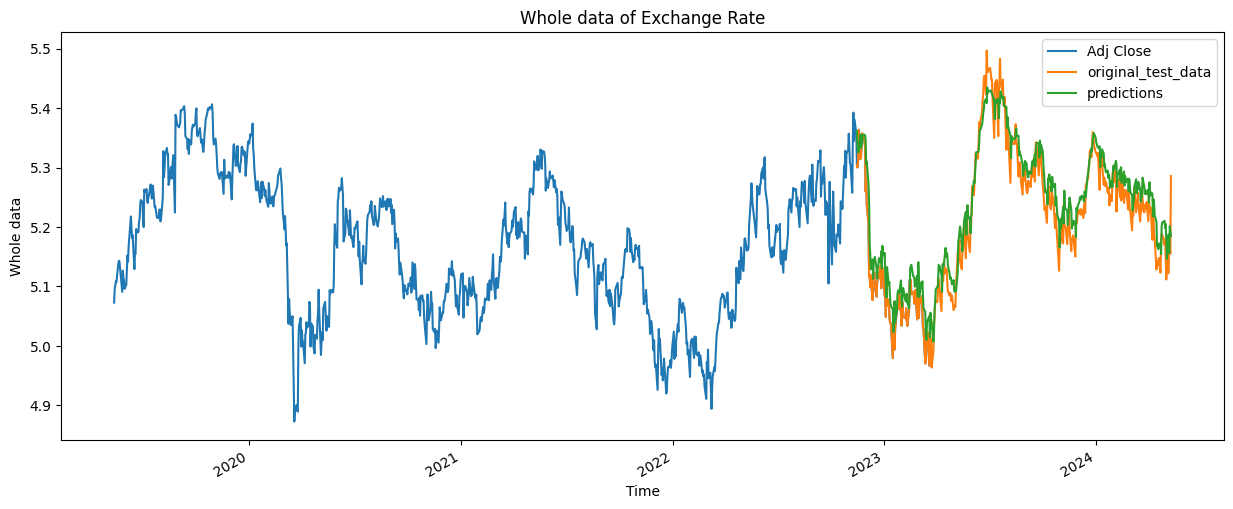

In [89]:
plot_graph((15,6), pd.concat([Adj_close_price[:splitting_len+100],ploting_data], axis=0), 'Whole data')

In [91]:
model.save("exchange_rate_predict_model.keras")